In [1]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
import os,sys
from PIL import Image
from helpers import *
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from pylab import *
from sklearn.model_selection import train_test_split

Using TensorFlow backend.
/Users/mac/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# Loaded a set of images
#root_dir = "augmented_training/"

root_dir = "training/"
image_dir = root_dir + "images/"
files = os.listdir(image_dir) 
sort_nicely(files)

n = 100

print("Loading " + str(n) + " satellite images")
imgs = [load_image(image_dir + files[i]) for i in range(n)] #List of each image Dim (100, 400,400,3)


gt_dir = root_dir + "groundtruth/"
files2 = os.listdir(gt_dir)
sort_nicely(files2)


print("Loading " + str(n) + " groundtruth images")
gt_imgs = [load_image(gt_dir + files2[i]) for i in range(n)]

print('Image size = ' + str(imgs[0].shape[0]) + ',' + str(imgs[0].shape[1]))

Loading 100 satellite images
Loading 100 groundtruth images
Image size = 400,400


In [3]:
patch_size = 16 # each patch is 16*16 pixels  #400/16 = 25*25 = 625 patches for 10 images

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]   # dim img_patches = (n,625,16,16,3)
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

# Linearize list of patches

X = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches = np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

print("img_patches:" + str(X.shape))
print("gt_patches:" + str(gt_patches.shape))

img_patches:(62500, 16, 16, 3)
gt_patches:(62500, 16, 16)


In [4]:
foreground_threshold = 0.25    
Y = np.asarray([value_to_class(np.mean(gt_patches[i]),foreground_threshold) for i in range(len(gt_patches))])
Y.shape

(62500,)

In [5]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2)

print("X_train:",X_train.shape)
print("X_val: ",X_val.shape)
print("Y_train",Y_train.shape)
print("Y_val",Y_val.shape)

X_train: (50000, 16, 16, 3)
X_val:  (12500, 16, 16, 3)
Y_train (50000,)
Y_val (12500,)


In [27]:
from keras.optimizers import Adam
from keras.layers import LeakyReLU
#from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau
from keras import backend as K
#reg = 1e-6

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', padding = 'same' ,input_shape=(16, 16, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu' , padding = 'same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(128, (3, 3), activation='relu' , padding = 'same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

#model.add(Conv2D(512, (3, 3), activation='relu' , padding = 'same'))
#model.add(Conv2D(512, (3, 3), activation='relu', padding = 'same'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.5))

model.add(Flatten())
#model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
opt = Adam(lr=0.001)
model.compile(loss='binary_crossentropy', optimizer = opt, metrics = ['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor=0.2,patience = 5, min_lr=0.00000001)
network_history = model.fit(X_train, Y_train, batch_size=128, epochs=40, validation_data = (X_val,Y_val), callbacks=[reduce_lr])
#network_history = model.fit(X_train, Y_train, batch_size=128, epochs=20, validation_data = (X_val,Y_val))

#network_history = model.fit(X, Y, batch_size=64, epochs=20)

score = model.evaluate(X_val, Y_val, batch_size=128)

Train on 50000 samples, validate on 12500 samples
Epoch 1/30
50000/50000 [==============================] - 166s 3ms/step - loss: 0.5263 - acc: 0.7424 - val_loss: 0.4747 - val_acc: 0.7558
Epoch 2/30
50000/50000 [==============================] - 187s 4ms/step - loss: 0.4510 - acc: 0.7762 - val_loss: 0.4069 - val_acc: 0.8047
Epoch 3/30
50000/50000 [==============================] - 163s 3ms/step - loss: 0.4152 - acc: 0.7976 - val_loss: 0.3845 - val_acc: 0.8153
Epoch 4/30
50000/50000 [==============================] - 164s 3ms/step - loss: 0.3942 - acc: 0.8135 - val_loss: 0.3894 - val_acc: 0.8132
Epoch 5/30
50000/50000 [==============================] - 213s 4ms/step - loss: 0.3790 - acc: 0.8215 - val_loss: 0.3543 - val_acc: 0.8311
Epoch 6/30
50000/50000 [==============================] - 190s 4ms/step - loss: 0.3693 - acc: 0.8273 - val_loss: 0.3483 - val_acc: 0.8415
Epoch 7/30
50000/50000 [==============================] - 182s 4ms/step - loss: 0.3613 - acc: 0.8299 - val_loss: 0.3463 - 

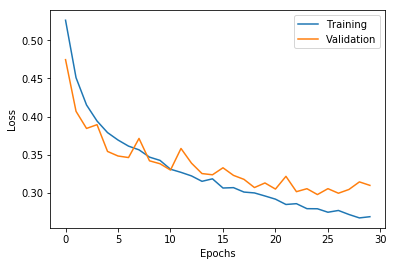

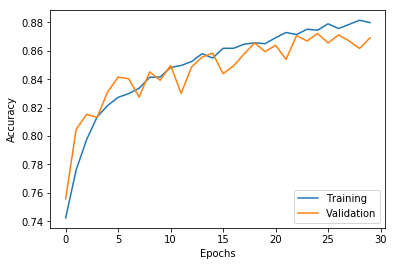

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['acc'])
    plt.plot(network_history.history['val_acc'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

plot_history(network_history)

## SUBMISSION 


In [29]:
test_dir = 'test_set_images/'

imgs_test = load_test_images(test_dir) ##In helpers.py
patch_size = 16 

img_patches_test = [img_crop(imgs_test[i], patch_size, patch_size) for i in range(len(imgs_test))]# dim img_patches
img_patches_test = np.asarray([img_patches_test[i][j] for i in range(len(img_patches_test)) for j in range(len(img_patches_test[i]))])

print("img_patches:" + str(img_patches_test.shape))

data = np.asarray([extract_features(img_patches_test[i]) for i in range(len(img_patches_test))])
print('Dataset (RGB features Mean/Variance) :', data.shape)


['test_set_images/test_1/test_1.png', 'test_set_images/test_2/test_2.png', 'test_set_images/test_3/test_3.png', 'test_set_images/test_4/test_4.png', 'test_set_images/test_5/test_5.png', 'test_set_images/test_6/test_6.png', 'test_set_images/test_7/test_7.png', 'test_set_images/test_8/test_8.png', 'test_set_images/test_9/test_9.png', 'test_set_images/test_10/test_10.png', 'test_set_images/test_11/test_11.png', 'test_set_images/test_12/test_12.png', 'test_set_images/test_13/test_13.png', 'test_set_images/test_14/test_14.png', 'test_set_images/test_15/test_15.png', 'test_set_images/test_16/test_16.png', 'test_set_images/test_17/test_17.png', 'test_set_images/test_18/test_18.png', 'test_set_images/test_19/test_19.png', 'test_set_images/test_20/test_20.png', 'test_set_images/test_21/test_21.png', 'test_set_images/test_22/test_22.png', 'test_set_images/test_23/test_23.png', 'test_set_images/test_24/test_24.png', 'test_set_images/test_25/test_25.png', 'test_set_images/test_26/test_26.png', 'te

In [30]:
y_pred = model.predict(img_patches_test, batch_size = 128)

In [35]:
for i in range(len(y_pred)):
    
    if y_pred[i] < 0.6:
        y_pred[i] = 0
    else:
        y_pred[i] = 1

print('prediction_shape: before',y_pred.shape)
labels = np.reshape(y_pred,(50,1444))
print('prediction_shape: after',labels.shape) ##iterate over each image more easily

prediction_shape: before (72200, 1)
prediction_shape: after (50, 1444)


In [36]:
imgwidth = imgs_test[0].shape[0] 
imgheight = imgs_test[0].shape[1] 
w = patch_size
h = patch_size

os.makedirs('prediction_convvv/', exist_ok=True) 

for i in range(len(labels)):
    im = label_to_img(imgwidth, imgheight, w, h, labels[i])
    im = img_float_to_uint8(im)
    Image.fromarray(im).save('prediction_convvv/prediction_' + '%.3d' % (i + 1)+ '.png')

[[1 2]
 [3 4]
 [5 6]]


400